**Making a plan that monitors while moving motors/ temperature controllers**


THe device being controlled should be a positioner that can be given a setpoint, but also be able to be controlled in terms of velocity/ ramp rate. 

In [6]:
from bluesky import RunEngine

RE = RunEngine({})

from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

#Get the databroker https://gist.github.com/untzag/53281819709b1058c7708a250cbd3676
from databroker.v2 import temp
db = temp()

# Insert all metadata/data captured into db.
RE.subscribe(db.v1.insert)

1

In [7]:

from ophyd.utils import OrderedDefaultDict
from ophyd.status import SubscriptionStatus, DeviceStatus
from ophyd import Device, EpicsSignal, EpicsSignalRO
import numpy as np
import os
import random
import threading
import time as ttime
import uuid
import weakref
import warnings
from ophyd.status import wait

from collections import deque, OrderedDict
from tempfile import mkdtemp

from ophyd.signal import Signal, EpicsSignal, EpicsSignalRO
from ophyd.areadetector.base import EpicsSignalWithRBV
from ophyd.status import DeviceStatus, StatusBase
from ophyd.device import (Device, Component as Cpt,
                     DynamicDeviceComponent as DDCpt, Kind)
from types import SimpleNamespace
from ophyd.pseudopos import (PseudoPositioner, PseudoSingle,
                        real_position_argument, pseudo_position_argument)
from ophyd.positioner import SoftPositioner
from ophyd.utils import ReadOnlyError, LimitError
from ophyd import PVPositioner
from ophyd import Component as Cpt
import time

class BasicFlyer(Device):   


    def __init__(self, prefix, *args, **kwargs):
        super().__init__(prefix, parent=None, **kwargs)
        self.complete_status = None
        self._acquiring = False
        self.t0 = 0
        
    
    def kickoff(self):
        """
        Start this Flyer, return a status object that sets finished once we have started
        """
        #logger.info("kickoff()")
        self.kickoff_status = DeviceStatus(self)
        self.complete_status = DeviceStatus(self)
        self._acquiring = True
        self.t0 = time.time()

        if self.init_cmd is not None:
            self.init_cmd.put(1)

        def check_value(*,old_value, value, **kwargs):
            #Return True when the acquisition is complete, False otherwise.   
            if not self._acquiring:  #But only report done if acquisition was already started 
                return False
            return (value != 0)
        
        wait(SubscriptionStatus(self.ready, check_value,settle_time=self.initial_delay.get()))

        if self.start_cmd is not None:
            self.start_cmd.put(1)
        
        # once started, we notify by updating the status object
        self.kickoff_status._finished(success=True)

        return self.kickoff_status

    def pause(self):

        self.stop_cmd.put(1)

        sta = DeviceStatus(self)
        sta._finished(success=True)
        return sta

    def resume(self):

        self.start_cmd.put(1)

        sta = DeviceStatus(self)
        sta._finished(success=True)
        return sta

    def stop(self):

        self.stop_cmd.put(1)
        self.complete_status._finished(success=True)
        sta = DeviceStatus(self)
        sta._finished(success=True)
        return sta

    def complete(self):
        """
        Wait for flying to be complete, get the status object that will tell us when we are done
        """
        print("we've be asked to complete")

        def check_value(*,old_value, value, **kwargs):
            #Return True when the acquisition is complete, False otherwise.   
            if not self._acquiring:  #But only report done if acquisition was already started 
                return False
            return (value != 0)

        if self.complete_status is None:
            raise RuntimeError("No collection in progress")
        
        print(f'settle_time is {self.settle_time.get()}')
        self.complete_status = SubscriptionStatus(self.done,check_value, settle_time = self.settle_time.get())
        return self.complete_status

    def collect(self):
        """
        Retrieve the data
        """
        # This is dummy data to test the formation of a list
        self.complete_status = None
        for _ in range(5):
            t = time.time()
            x = t - self.t0 
            d = dict(
                time=t,
                data={self.name+'_pos':x},
                timestamps=dict(x=t)
            )
            yield d
        
    
    def describe_collect(self):
 
        """
        Describe details for ``collect()`` method
        """
        d = dict(
            source = "elapsed time, s",
            dtype = "number",
            shape = []
        )
        return {
            self.name: {
                self.name+'_pos': d
            }
        }


class MyDetector(Device):
    
    count =  Cpt(EpicsSignalRO,'sensor4:getCount', kind='hinted') 


class MyMotor(BasicFlyer):
    
    start_pos = Cpt(EpicsSignal,'axis4:setStartPos', kind='config') 
    end_pos = Cpt(EpicsSignal,'axis4:setEndPos', kind='config')
    pos = Cpt(EpicsSignalRO,'axis4:getPos', kind='hinted') 
    velocity = Cpt(EpicsSignal,'axis4:setVel', kind='config')
    start_cmd = Cpt(EpicsSignal, 'axis4:start.PROC', kind='config')
    stop_cmd = Cpt(EpicsSignal, 'axis4:stop.PROC', kind='config')
    init_cmd = Cpt(EpicsSignal, 'axis4:init.PROC', kind='config')
    done = Cpt(EpicsSignal, 'axis4:done', kind='config')
    ready = Cpt(EpicsSignal, 'axis4:ready', kind='config')
    settle_time = Cpt(Signal, value=0)
    initial_delay = Cpt(Signal, value=0) #The time to wait after we report that we are ready. not needed if your device can be set an abs position
    read_attrs = ['pos']



In [8]:
# The flying plan

from bluesky import plan_stubs as bps
from bluesky import preprocessors as bpp
from functools import partial
import numpy as np

from bluesky.utils import (
    separate_devices,
    all_safe_rewind,
    Msg,
    ensure_generator,
    short_uid as _short_uid,
)

from ophyd import Signal
  
def flyscan_reactor(detectors, flyer, start=None, stop=None, dwell=None, vel =0.2, delay=0.2,*, md=None):
    
    """
    count detectors while flying a flyer with start, stop, initial scan velocity, and the delay between det sample time

    The flyer object should implement the ophyd flyer device methods, although we don't use the collect method, instead we poll all of the detectors in the detectors list, as well as the parameters in the read_args of the flyer object.

    Parameters
    ----------
    detectors : list
        list of 'readable' objects
    flyer :
        Object of FlyerDevice type
    start : float
        The start value fo the flyer
    stop : float
        The stop value of the flyer
    dwell : list
        float of how long in seconds to wait at the stop point   
    vel : list
        The ramp rate between start and stop. list of floats
    delay : iterable or scalar, optional
        Time delay in seconds between successive readings; default is 0.2
    md : dict, optional
        metadata

    """
    
    # TODO
    # Add test that detectors is a list longer than 0
    
    #Add the flyer to the list of things we want to count
    detectors_list = detectors.append(flyer)
    
    
    #Define the motor metadata (important for plotting)
    motor = flyer
    md = md or {}

    del_req = delay

    

    flyer.velocity.put(vel)

    md_args = [repr(motor),start,stop,vel,del_req]
    x_fields = []
    x_fields.extend(getattr(motor, 'hints', {}).get('fields', []))

    _md = {'detectors': [det.name for det in detectors],
           'motors': x_fields,
           'plan_args': {'detectors': list(map(repr, detectors)),
                         'motors' : flyer.name,
                         'start': start, 
                         'stop' : stop,
                         'vel': vel,
                         'delay': del_req,
                         'args':md_args
                         },

           'plan_name': 'flycount',
           'hints': {},
       }
    _md.update(md or {})
    
    # Deterime the name of the x axis for plotting from the flyer
    default_dimensions = [(x_fields, 'primary')]
    default_hints = {}
    
    # The following is left from the scan plan implementation, assumes multiple motors
    if len(x_fields) > 0:
        default_hints.update(dimensions=default_dimensions)

    # now add default_hints and override any hints from the original md (if
    # exists)
    
    _md['hints'] = default_hints
    _md.update(md)
  
    # Configure the flyer (but don't yet init or start)
    flyer.start_pos.put(start)
    flyer.end_pos.put(stop)
    #Need to add settle time here so that kickoff waits
    flyer.settle_time.put(dwell)
    
    # Init the run
    uid = yield from bps.open_run(_md)
    
    # Start the flyer and wait until it's reported that it's started
    yield from bps.kickoff(flyer, wait=True)

    # Get the status object that tells us when it's done
    complete_status = yield from bps.complete(flyer, wait=False)

    
    
    while not complete_status.done:

        yield Msg('checkpoint') # allows us to pause the run 
        yield from bps.one_shot(detectors) #triggers and reads everything in the detectors list
        yield Msg('sleep', None, del_req)

    #Now sleep after it's finished

    yield from bps.close_run()
    return uid


In [17]:
# https://nsls-ii.github.io/bluesky/multi_run_plans.html#plans-with-sequential-runs


def sequential_reactor_plan(detectors,controller , starts, stops, ramp_rates, dwell_times,initial_delay= 0, delay = None, per_step=None, md=None):
    # Single-run plans may be called consecutively. No special handling is required
    #   as long as the previous scan is closed before the next one is opened
    
    #move to the initial temp
    controller.start_pos.set(starts[0])
    controller.initial_delay.set(initial_delay)
    # Start the flyer and wait until it's reported that it's started
    print(f"We're starting, waiting to move to start and for intitial delay")
    
    wait(controller.kickoff())

    for x in range(len(starts)):
        print(f'moving to start {starts[x]} stop {stops[x]} with dwell time {dwell_times[x]} and ramp rate {ramp_rates[x]}')
        yield from flyscan_reactor(detectors, controller, start=starts[x], stop=stops[x], dwell=dwell_times[x], vel =ramp_rates[x], delay=delay, md=None)





In [22]:

my_det = MyDetector('EMILEL:TestIOC00:', name='my_det')
temp_cont = MyMotor('EMILEL:TestIOC00:', name='temp_cont')
temp_cont.wait_for_connection()

We're starting, waiting to move to start and for intitial delay
moving to start 1 stop 2 with dwell time 1 and ramp rate 0.1


Transient Scan ID: 11     Time: 2021-10-13 18:49:22
Persistent Unique Scan ID: '0adc4018-e344-4709-917c-b4af43df0ab0'
we've be asked to complete
settle_time is 1
New stream: 'primary'
+-----------+------------+---------------+--------------+
|   seq_num |       time | temp_cont_pos | my_det_count |
+-----------+------------+---------------+--------------+
|         1 | 18:49:27.9 |             2 |        65109 |
|         2 | 18:49:28.0 |             2 |        65294 |
|         3 | 18:49:28.2 |             2 |        65426 |
|         4 | 18:49:28.3 |             2 |        65473 |
|         5 | 18:49:28.5 |             2 |        65507 |
|         6 | 18:49:28.6 |             2 |        65535 |
|         7 | 18:49:28.7 |             2 |        65530 |
|         8 | 18:49:28.9 |             2 |        65511 |
|         9 | 18:49:29.0 |             2 |        6

('0adc4018-e344-4709-917c-b4af43df0ab0',
 '60b3930f-a40f-40e0-afab-b3e5063dae85')

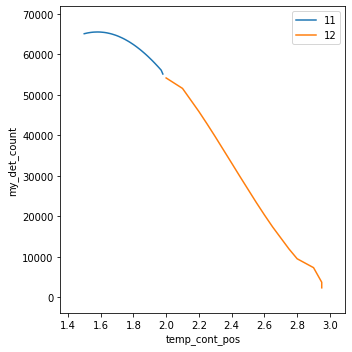

In [23]:
RE(sequential_reactor_plan([my_det],temp_cont,[1,2],[2,3],[0.1,0.5],[1,3],initial_delay = 5,delay=0.1))

In [26]:
#Note that in the above plan we define the metadata such that the temperature controller position is plotted against the detector counts. This might not be what you want. 
#All the data is saved and timestamped. If you want the best effort callback to plot somthing different you need to modify the md (metadata) that is saved along with it in the plan
run = db[-1]
run.primary.read()

<xarray.Dataset>
Dimensions:                  (time: 34)
Coordinates:
  * time                     (time) float64 1.634e+09 1.634e+09 ... 1.634e+09
Data variables:
    my_det_count             (time) float64 5.419e+04 5.16e+04 ... 2.376e+03
    temp_cont_pos            (time) float64 2.0 2.1 2.2 2.25 ... 2.95 2.95 2.95
    temp_cont_settle_time    (time) int64 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3
    temp_cont_initial_delay  (time) int64 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5

In [ ]:
#